Spline 2D test
[0.66, 2.53, 2.53, 2.53, 2.53, 5.44, 5.44, 8.18, 8.18, 8.49, 8.49, 10.31, 10.31, 10.31, 10.31, 8.18, 8.18, 8.18, 8.18]
[5.09, 5.09, 5.09, 3.56, 3.56, 3.56, 3.56, 3.56, 3.56, 2.43, 2.43, 2.61, 2.61, 3.68, 3.68, 3.56, 3.56, 5.91, 5.91]


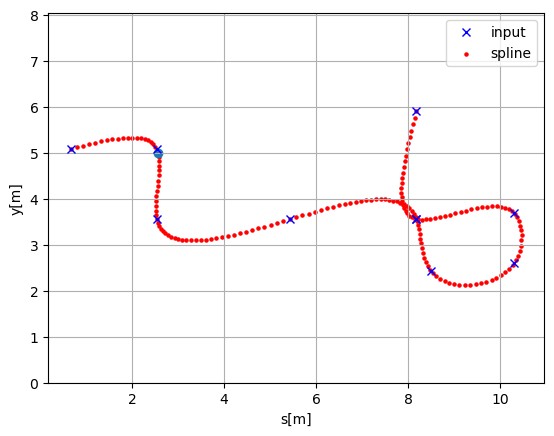

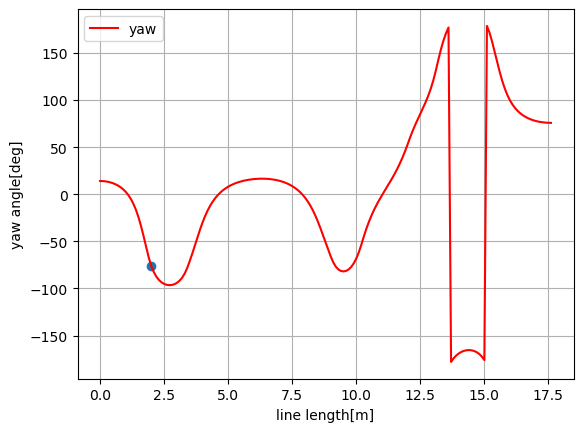

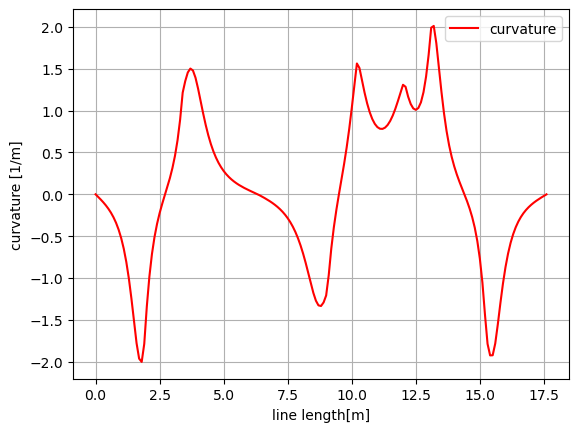

In [38]:
import numpy as np
import math
import bisect

class Spline():
    u"""
    Cubic Spline class
    """

    def __init__(self, x, y, max_curvature=None):
        self.b, self.c, self.d, self.w = [], [], [], []

        self.x = x
        self.y = y

        self.nx = len(x)  # dimension of s
        h = np.diff(x) + 1e-10
        # print(h)
        # calc coefficient cBest
        self.a = [iy for iy in y]

        # calc coefficient cBest
        A = self.__calc_A(h, max_curvature)
        B = self.__calc_B(h, max_curvature)
        self.c = np.linalg.solve(A, B)
        #  print(self.c1)

        # calc spline coefficient b and d
        for i in range(self.nx - 1):
            self.d.append((self.c[i + 1] - self.c[i]) / (3.0 * h[i]))
            tb = (self.a[i + 1] - self.a[i]) / h[i] - h[i] * (self.c[i + 1] + 2.0 * self.c[i]) / 3.0
            self.b.append(tb)

    def calc(self, t):
        u"""
        Calc position

        if t is outside of the input s, return None

        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.a[i] + self.b[i] * dx + \
            self.c[i] * dx ** 2.0 + self.d[i] * dx ** 3.0

        return result

    def calcd(self, t):
        u"""
        Calc first derivative

        if t is outside of the input s, return None
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.b[i] + 2.0 * self.c[i] * dx + 3.0 * self.d[i] * dx ** 2.0
        return result

    def calcdd(self, t):
        u"""
        Calc second derivative
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = 2.0 * self.c[i] + 6.0 * self.d[i] * dx
        return result

    def __search_index(self, x):
        u"""
        search data segment index
        """
        return bisect.bisect(self.x, x) - 1

    def __calc_A(self, h, max_curvature):
        A = np.zeros((self.nx, self.nx))
        A[0, 0] = 1.0
        for i in range(self.nx - 1):
            if i != (self.nx - 2):
                A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])

                # Apply the curvature constraint if provided
                if max_curvature is not None:
                    curvature_limit = max_curvature * h[i] * h[i + 1]
                    A[i + 1, i + 1] = min(A[i + 1, i + 1], curvature_limit)

            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[0, 1] = 0.0
        A[self.nx - 1, self.nx - 2] = 0.0
        A[self.nx - 1, self.nx - 1] = 1.0
        return A

    def __calc_B(self, h, max_curvature):
        B = np.zeros(self.nx)
        for i in range(self.nx - 2):
            B[i + 1] = 3.0 * (self.a[i + 2] - self.a[i + 1]) / h[i + 1] - 3.0 * (self.a[i + 1] - self.a[i]) / h[i]

            # Apply the curvature constraint if provided
            if max_curvature is not None:
                curvature_limit = max_curvature * h[i] * h[i + 1]
                B[i + 1] = min(B[i + 1], curvature_limit)
                B[i + 1] = max(B[i + 1], -curvature_limit)
        return B


class Spline2D:
    u"""
    2D Cubic Spline class

    """

    def __init__(self, x, y, max_curvature=None):
        self.s = self.__calc_s(x, y)
        self.sx = Spline(self.s, x, max_curvature)
        self.sy = Spline(self.s, y, max_curvature)

    def __calc_s(self, x, y):
        dx = np.diff(x)
        dy = np.diff(y)
        self.ds = [math.sqrt(idx ** 2 + idy ** 2)
                   for (idx, idy) in zip(dx, dy)]
        s = [0]
        s.extend(np.cumsum(self.ds))
        return s

    def calc_position(self, s):
        u"""
        calc position
        """
        x = self.sx.calc(s)
        y = self.sy.calc(s)

        return x, y

    def calc_curvature(self, s):
        u"""
        calc curvature
        """
        dx = self.sx.calcd(s)
        ddx = self.sx.calcdd(s)
        dy = self.sy.calcd(s)
        ddy = self.sy.calcdd(s)
        k = (ddy * dx - ddx * dy) / (dx ** 2 + dy ** 2)
        return k

    def calc_yaw(self, s):
        u"""
        calc yaw
        """
        dx = self.sx.calcd(s)
        dy = self.sy.calcd(s)
        yaw = math.atan2(dy, dx)
        return yaw


def calc_spline_course(x, y, ds=0.1):
    sp = Spline2D(x, y)
    s = np.arange(0, sp.s[-1], ds)

    rx, ry, ryaw, rk = [], [], [], []
    for i_s in s:
        ix, iy = sp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        ryaw.append(sp.calc_yaw(i_s))
        rk.append(sp.calc_curvature(i_s))

    return rx, ry, ryaw, rk, s

def insert_additional_points(x, y, num_points):
    new_x, new_y = [], []

    for i in range(len(x) - 1):
        new_x.extend(np.linspace(x[i], x[i+1], num_points))
        new_y.extend(np.linspace(y[i], y[i+1], num_points))

    new_x.append(x[-1])
    new_y.append(y[-1])

    return new_x, new_y

def test_spline2d():
    print("Spline 2D test")
    import matplotlib.pyplot as plt
    # x = [-2.5, 0.0, 2.5, 5.0, 7.5, 3.0, -1.0]
    # y = [0.7, -6, 5, 6.5, 0.0, 5.0, -2.0]
    
    x = [0.66, 2.53, 2.53, 5.44, 8.18, 8.49, 10.31, 10.31]
    y = [5.09, 5.09, 3.56, 3.56, 3.56, 2.43, 2.61, 3.68]
    
    x = [0.66, 2.53, 2.53, 5.44, 8.18, 8.49, 10.31, 10.31, 8.18, 8.18]
    y = [5.09, 5.09, 3.56, 3.56, 3.56, 2.43, 2.61, 3.68, 3.56, 5.91]
    new_x, new_y = insert_additional_points(x, y, 2)
    print(new_x)
    print(new_y)
    # raise
    new_x, new_y = x, y
    max_curvature = 50
    sp = Spline2D(new_x, new_y)
    s = np.arange(0, sp.s[-1], 0.1)

    rx, ry, ryaw, rk = [], [], [], []
    for i_s in s:
        ix, iy = sp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        ryaw.append(sp.calc_yaw(i_s))
        rk.append(sp.calc_curvature(i_s))

    flg, ax = plt.subplots(1)
    plt.plot(x, y, "xb", label="input")
    plt.scatter(rx, ry, c="r", s=5, label="spline")
    plt.scatter(rx[20], ry[20])
    plt.grid(True)
    plt.axis("equal")
    plt.xlabel("s[m]")
    plt.ylabel("y[m]")
    plt.legend()

    flg, ax = plt.subplots(1)
    plt.plot(s, [math.degrees(iyaw) for iyaw in ryaw], "-r", label="yaw")
    plt.scatter(s[20], math.degrees(ryaw[20]))
    plt.grid(True)
    plt.legend()
    plt.xlabel("line length[m]")
    plt.ylabel("yaw angle[deg]")

    flg, ax = plt.subplots(1)
    plt.plot(s, rk, "-r", label="curvature")
    plt.grid(True)
    plt.legend()
    plt.xlabel("line length[m]")
    plt.ylabel("curvature [1/m]")

    plt.show()

if __name__ == '__main__':
    # test_spline()
    test_spline2d()

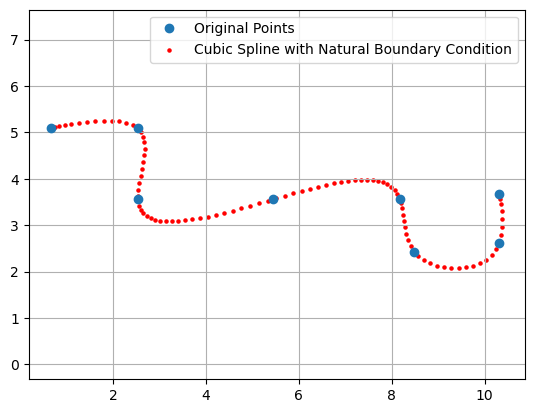

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

x = np.array([0.66, 2.53, 2.53, 5.44, 8.18, 8.49, 10.31, 10.31])
y = np.array([5.09, 5.09, 3.56, 3.56, 3.56, 2.43, 2.61, 3.68])

# Calculate the arc length
ds = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
s = np.hstack(([0], np.cumsum(ds)))

# Create the cubic spline using the arc length as the parameter
cs = CubicSpline(s, y, bc_type='clamped')

# Generate interpolation points
t = np.linspace(s[0], s[-1], num=100)
interpolated_y = cs(t)

# Interpolate x-values
cs_x = CubicSpline(s, x, bc_type='clamped')
interpolated_x = cs_x(t)

plt.plot(x, y, 'o', label='Original Points')
plt.scatter(interpolated_x, interpolated_y, s=5, c='r', label='Cubic Spline with Natural Boundary Condition')
plt.legend(loc='best')
plt.grid(True)
plt.axis('equal')
plt.show()


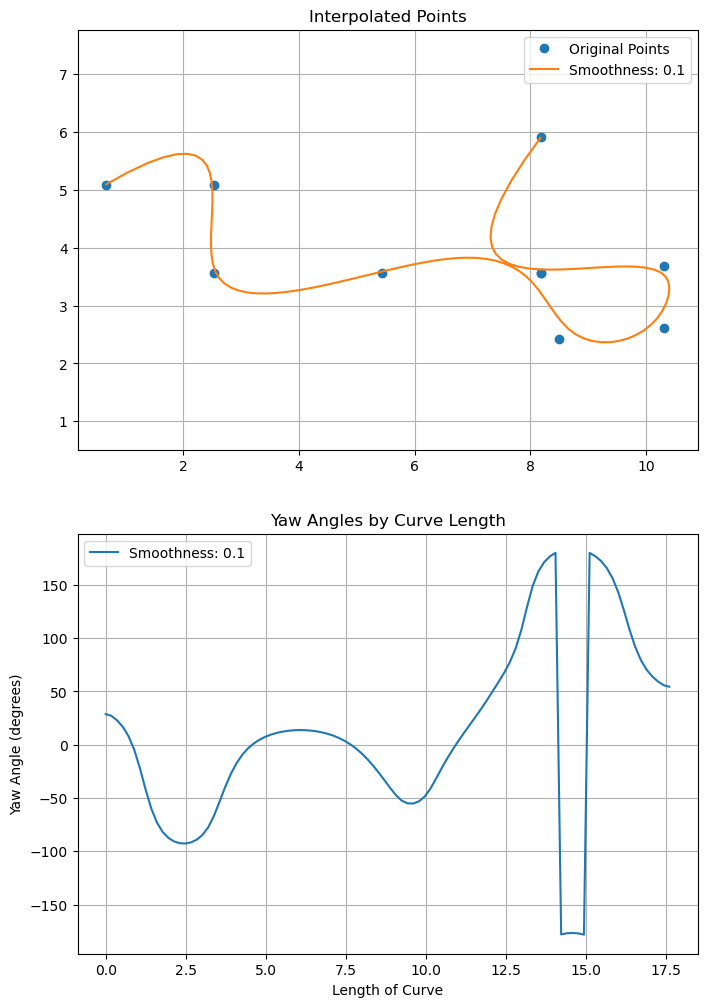

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev

def calc_yaw(dx, dy):
    return np.arctan2(dy, dx)

x = [0.66, 2.53, 2.53, 5.44, 8.18, 8.49, 10.31, 10.31, 8.18, 8.18]
y = [5.09, 5.09, 3.56, 3.56, 3.56, 2.43, 2.61, 3.68, 3.56, 5.91]

# Calculate the arc length
ds = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
s = np.hstack(([0], np.cumsum(ds)))

# Tune the smoothness factor
smoothness = [0.1]

# Generate interpolation points
t = np.linspace(s[0], s[-1], num=100)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 12))
ax1.plot(x, y, 'o', label='Original Points')

# Interpolate with different smoothness factors
for sm in smoothness:
    tck = splrep(s, y, s=sm)
    interpolated_y = splev(t, tck)
    
    tck_x = splrep(s, x, s=sm)
    interpolated_x = splev(t, tck_x)

    ax1.plot(interpolated_x, interpolated_y, label=f'Smoothness: {sm}')
    
    # Calculate the yaw angles
    dx = np.gradient(interpolated_x)
    dy = np.gradient(interpolated_y)
    yaw_angles = calc_yaw(dx, dy)
    
    ax2.plot(t, np.rad2deg(yaw_angles), label=f'Smoothness: {sm}')

ax1.legend(loc='best')
ax1.grid(True)
ax1.axis('equal')
ax1.set_title('Interpolated Points')

ax2.legend(loc='best')
ax2.grid(True)
ax2.set_xlabel('Length of Curve')
ax2.set_ylabel('Yaw Angle (degrees)')
ax2.set_title('Yaw Angles by Curve Length')

plt.show()


Using PchipInterpolator to genreate piecewise trajectory


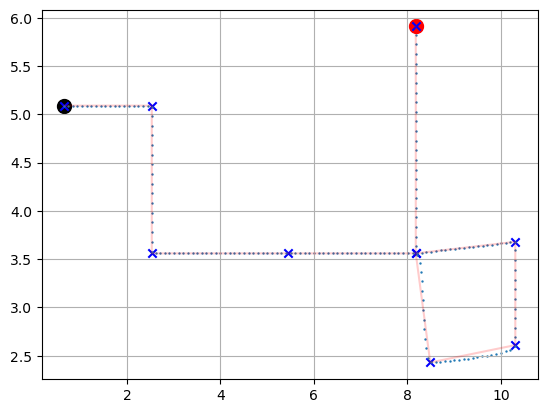

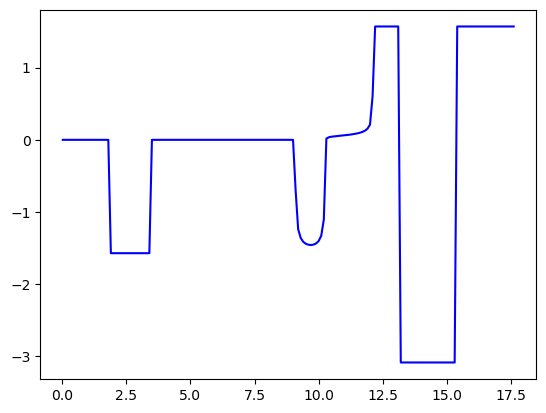

In [6]:
import scipy.interpolate as interp
import numpy as np
import matplotlib.pyplot as plt

np.seterr(all='ignore')
np.set_printoptions(precision=3, suppress=True)

def arc_length(path, t, dt):
    derivative = path.derivative()(t)
    return np.sqrt(np.sum(derivative**2, axis=1)) * dt

x = [0.66, 2.53, 2.53, 5.44, 8.18, 8.49, 10.31, 10.31, 8.18, 8.18]
y = [5.09, 5.09, 3.56, 3.56, 3.56, 2.43, 2.61, 3.68, 3.56, 5.91]
Nw = len(x)
waypoints = np.column_stack((x, y))
path = interp.PchipInterpolator(np.linspace(0, 1, Nw), waypoints, axis=0)
# Calculate even trajectory points
t = np.linspace(0, 1, 1000)
dt = t[1] - t[0]
cumulative_arclength = np.cumsum(arc_length(path, t, dt))
point_distance = 0.1
total_arclength = cumulative_arclength[-1]
num_points = int(np.ceil(total_arclength / point_distance))
even_t = np.zeros(num_points)
current_arclength = 0
for i in range(1, num_points):
    current_arclength += point_distance
    even_t[i] = np.interp(current_arclength, cumulative_arclength, t)
even_trajectory = path(even_t)

# calculate yaw angles at each point
even_arclength = np.interp(even_t, t, cumulative_arclength)
# Calculate yaw angles at each point
path_derivative = path.derivative()(even_t)
yaw_angles = np.arctan2(path_derivative[:, 1], path_derivative[:, 0])

# plot waypoints
plt.scatter(waypoints[0,0], waypoints[0,1], s=100, c='k',  label="Start")
plt.scatter(waypoints[-1,0], waypoints[-1,1], s=100, c='r', label="End")
plt.scatter(waypoints[:, 0], waypoints[:, 1], c='b', marker='x',label="Waypoints")
plt.plot(waypoints[:, 0], waypoints[:, 1], 'r', alpha=0.2)
# Plot the trajectory
plt.scatter(even_trajectory[:, 0], even_trajectory[:, 1], s=2, marker='.', label="Trajectory")
plt.grid()

fig, ax = plt.subplots()
plt.plot(even_arclength, yaw_angles, 'b-', label="Yaw angle")